<a href="https://colab.research.google.com/github/fuse999/DS-Unit-2-Kaggle-Challenge/blob/master/module1/Riley_assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'


     |████████████████████████████████| 102kB 2.4MB/s 


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [51]:
# Do train/validate/test split with the Tanzania Waterpumps data.

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [52]:
train, val = train_test_split(train, train_size=0.80,
                              test_size=0.20, stratify=train['status_group'], random_state=42)
train.shape, val.shape

((47520, 41), (11880, 41))

In [0]:
train.population.unique()

In [0]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning (in acordince with lectuere)
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # replace the zeros with nulls.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    cols_with_zeros = ['population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    cols_with_zeros = ['construction_year']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    cols_with_zeros = ['amount_tsh']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    # duplicates, so drop them
    X = X.drop(columns='quantity')
    X = X.drop(columns='quality_group')
    X = X.drop(columns='waterpoint_type_group')
    X = X.drop(columns='extraction_type_group')
    X = X.drop(columns='extraction_type_class')
    X = X.drop(columns='payment')
    X = X.drop(columns='source_type')
    X = X.drop(columns='scheme_management')
  
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['year_inspected'] = pd.DatetimeIndex(X['date_recorded']).year
    X['years_since_inspection'] = X['year_inspected'] - X['construction_year']
    X = X.drop(columns='year_inspected')

    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [55]:
# creating target and features lsts
target = 'status_group'
train_features = train.drop(columns=[target, 'id'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'years_since_inspection', 'basin', 'region', 'public_meeting', 'recorded_by', 'permit', 'extraction_type', 'management', 'management_group', 'payment_type', 'water_quality', 'quantity_group', 'source', 'source_class', 'waterpoint_type']


In [0]:
# creating Train, Validation, and Test vars
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [62]:
# pipeline for LogisticRegression
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Validation Accuracy 0.7364478114478115


In [0]:
# I think the pipeline method is better most of the time

In [63]:
# pipeline for DecisionTreeClassifier
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=18, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_test)

Train Accuracy 0.8712121212121212
Validation Accuracy 0.7725589225589226


In [0]:
# Get your validation accuracy score.
# Validation Accuracy 0.7725589225589226

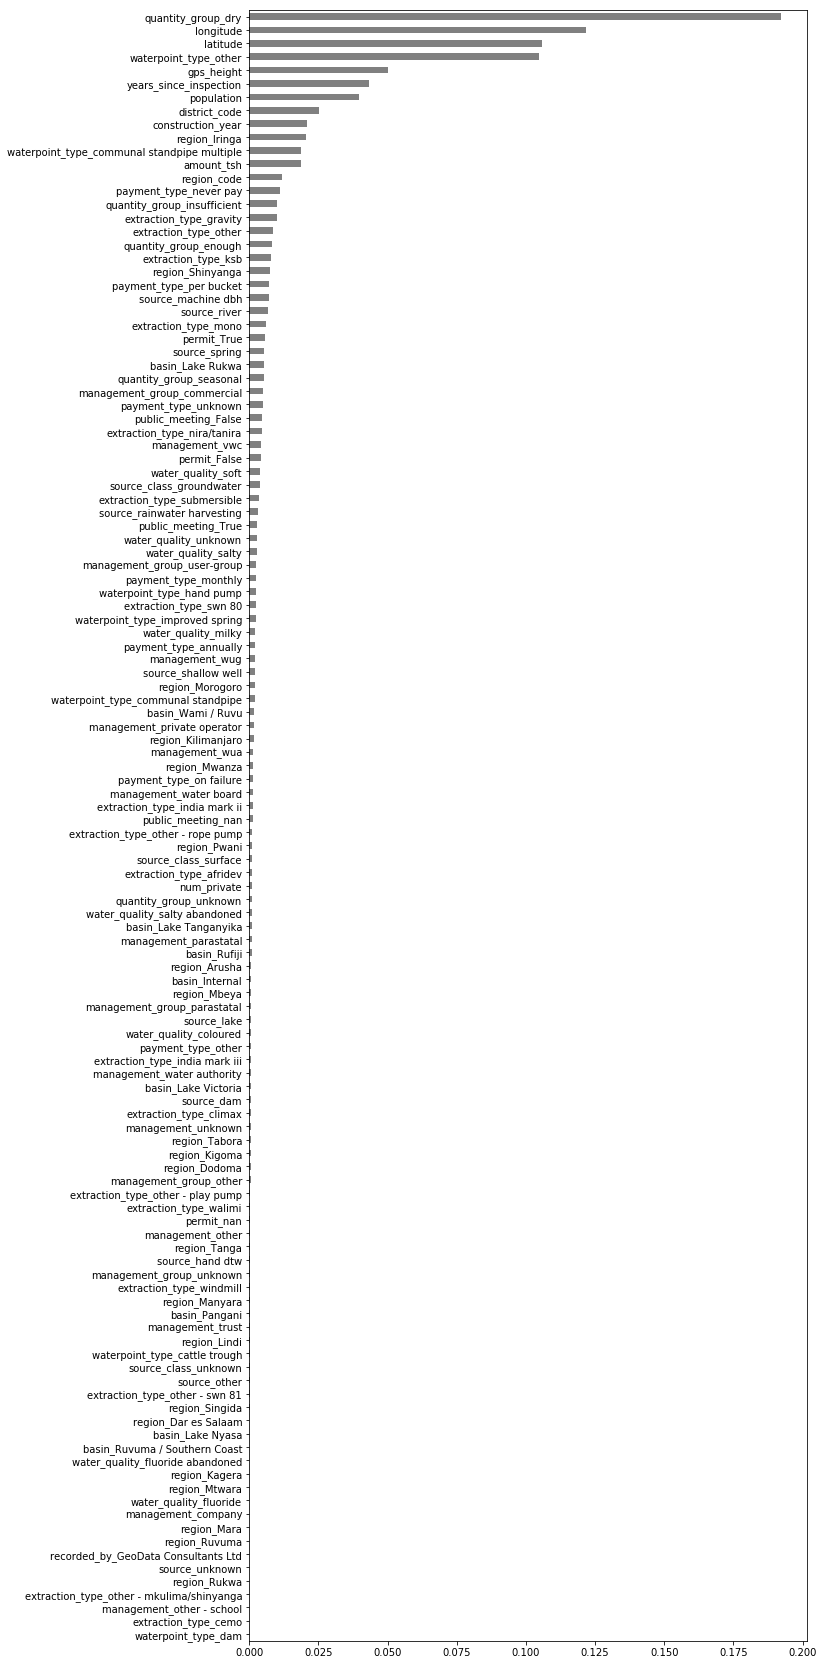

In [61]:
# Get and plot your feature importances.

%matplotlib inline

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [0]:
# estimator is your model or pipeline, which you've fit on X_train
 
# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train
 
 y_pred = pipeline.predict(X_test)
 
# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index
 

sample_submission = sample_submission.copy()
sample_submission['status_group'] = y_pred
sample_submission.to_csv('riley_base.csv', index=False)

In [0]:
from google.colab import files
files.download('riley_base.csv')